# Probability of market going up next day

### Wouldn't it be nice if we could predict with some degree of probability whether the stock market is going to go up tomorrow?

In [ ]:
### Business question and domain knowledge_ Explicamos
### Se trata de poder predecir la probabilidad que tenemos de que al día siguiente el mercado (índice S&P500) suba teniendo en cuenta los ciertos datos obtenidos hoy (features)


## 2. Dataset

### 2.1. Dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.tsa.api as smt


### 2.2 Import Dataset

In [2]:
df = pd.read_excel("Midproject_dataset_pre_alt.xlsx")

In [3]:
df.head(10)

,DATE,ES,AVG(5)[1],AVG(200)[1],RSI(2)[1],VIX[1],EUR-USD[1],10YR_IR[1],CRUDE OIL[1],NG[1],...,RSI(2),VIX,Change VIX,Change EUR-USD,Change 10YR_IR,Change CRUDE OIL,Change NG,Change GOLD,S&P500 RET,RET_LABEL
0,2004-10-13,1112.00,1129.00,1119.98500,25.759886,15.05,1.2324,112.828,52.51,6.636,...,25.759886,15.05,0.000000,-0.006530,-0.002221,-0.015007,-0.073573,-0.018610,-0.009133,0
1,2004-10-14,1103.00,1122.80,1119.93625,8.580459,15.42,1.2342,113.094,53.64,6.851,...,8.580459,15.05,0.024585,0.001461,-0.002358,0.021520,0.032399,-0.004801,-0.008094,1
2,2004-10-15,1108.75,1117.05,1119.82375,3.952030,16.43,1.2384,113.531,54.76,6.803,...,3.952030,15.42,0.065499,0.003403,-0.003864,0.020880,-0.007006,0.011819,0.005213,1
3,2004-10-18,1112.75,1114.40,1119.71875,43.141736,15.04,1.2470,113.219,54.93,6.709,...,43.141736,16.43,-0.084601,0.006944,0.002748,0.003104,-0.013817,0.001430,0.003608,0
4,2004-10-19,1103.50,1111.75,1119.68125,63.731022,14.71,1.2493,113.234,53.67,6.806,...,63.731022,15.04,-0.021941,0.001844,-0.000132,-0.022938,0.014458,-0.005951,-0.008313,0
5,2004-10-20,1101.50,1108.00,1119.55750,23.826584,15.13,1.2512,113.281,53.29,7.123,...,23.826584,14.71,0.028552,0.001521,-0.000415,-0.007080,0.046577,0.009579,-0.001812,1
6,2004-10-21,1108.25,1105.90,1119.45875,18.749832,14.85,1.2589,113.625,54.92,7.623,...,18.749832,15.13,-0.018506,0.006154,-0.003037,0.030587,0.070195,0.007590,0.006128,1
7,2004-10-22,1095.25,1106.95,1119.34500,66.676560,14.54,1.2613,113.578,54.47,7.697,...,66.676560,14.85,-0.020875,0.001906,0.000414,-0.008194,0.009707,0.001883,-0.011730,0
8,2004-10-25,1095.25,1104.25,1119.15500,20.377441,15.28,1.2682,113.734,55.17,8.105,...,20.377441,14.54,0.050894,0.005471,-0.001374,0.012851,0.053008,0.000000,0.000000,1
9,2004-10-26,1111.50,1100.75,1118.93750,20.377441,16.58,1.2806,113.891,54.54,7.890,...,20.377441,15.28,0.085079,0.009778,-0.001380,-0.011419,-0.026527,0.010103,0.014837,1


In [4]:
df.columns

Index(['DATE', 'ES', 'AVG(5)[1]', 'AVG(200)[1]', 'RSI(2)[1]', 'VIX[1]',
       'EUR-USD[1]', '10YR_IR[1]', 'CRUDE OIL[1]', 'NG[1]', 'GOLD[1]',
       'Change AVG(5)', 'C - AVG(200)', 'RSI(2)', 'VIX', 'Change VIX',
       'Change EUR-USD', 'Change 10YR_IR', 'Change CRUDE OIL', 'Change NG',
       'Change GOLD', 'S&P500 RET', 'RET_LABEL'],
      dtype='object')

In [5]:
### Data cleaning is already performed through Excel---
### Try to do de data cleaning through Python in case we have got spare time in the end

### Data cleaning steps
### Data was retrieved from esignal service (all but gold) and from https://www.kaggle.com/datasets/psycon/daily-gold-price-historical-data  for gold prices
### Step 1: Each symbol consist of a pair columns (Date,Close). We retrieve all information for each symbol separately\n",
### Step 2: Each symbol different dates (they belong to different Exchanges and trading activity and trading hours/holidays might be different)
### Step 3: Date format need to be changed from (DTYYYYMMDD) to ((MM/DD/YYYY). Date is not important for the project but it is to align the different symbols sets
### Step 4: Technical Indicators on the underlying (AVG(5),AVG(200) & RSI) must be calculated from underlying data (S&P500)
### Step 5: All symbols must be joined/grouped in a single DataFrame accoriding to Date\n",
### Step 6: Transform Data: We are not interested on actual values of S&P500 but on whether it ahs gone up or down. We get return and then a categorical value for it
###  Up: 1 ; Down: 0\n",
### Step 7: Features need to be transformed: We are typically more interested in knowing how other markets have changed (their daily return) than in actual quotes
###        Sometimes there is important information on actual values (i.e VIX or RSI). I case of AVG(200) we just want to know if we are in a long term upside regime (1 or not 0)
### Step 8: VERY, VERY IMPORTANT!!!! 
    ##        Features must belong to prior date. We want to predict if TOMORROW the market is going to go up with TODAY´s information. So we need to make sure that all features information
    ##        has 1 day-lag (For each date , we have S&P500 return (up or down) for the day and features values must belong to yesterdays activity)

## 3. EDA

### 3.1 Stylized Facts

#### Stylized facts is like a specific EDA for asset returns time series. Asset returns typically show some statistical properties that do not appear in other areas
#### It is important to know them in order to build models



<br>

#### 0.-   S&P500 Returns
***

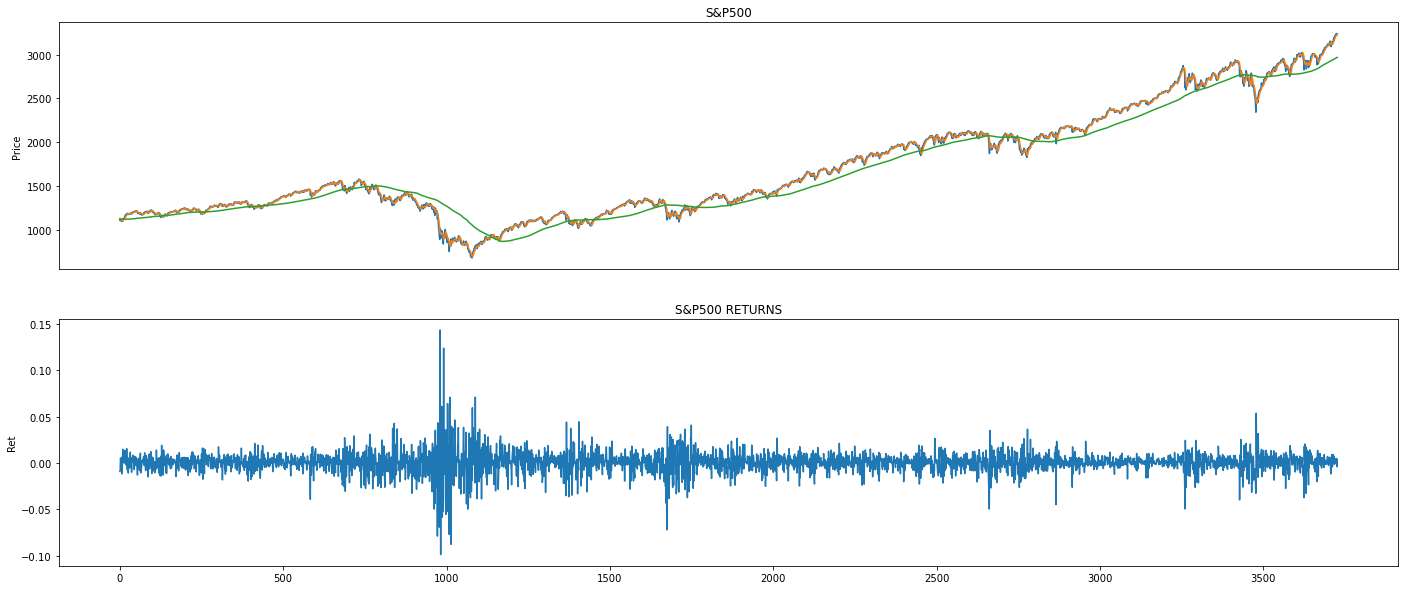

In [6]:
# Lets plot the S&P500 and its returns

sma5=df["AVG(5)[1]"]
sma200=df["AVG(200)[1]"]

fig,ax = plt.subplots(2,1,figsize=(24,10),sharex=True)
df.ES.plot(ax=ax[0])
sma5.plot(ax=ax[0])
sma200.plot(ax=ax[0])
ax[0].set(title='S&P500',ylabel = "Price")

df["S&P500 RET"].plot(ax=ax[1])
ax[1].set(title='S&P500 RETURNS',ylabel = "Ret")

ax[0].get_xaxis().set_visible(False)


<br>

#### 1.- Gaussian Returns?
***

In [7]:
ret = df['S&P500 RET']
rng =  np.linspace(min(ret),max(ret),num=1000)
mu = ret.mean()
sigma = ret.std()
norm_pdf = stats.norm.pdf(rng,loc=mu,scale=sigma)

In [8]:
# We plot the histogram & QQplot

C:\Users\cprieto\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Q-Q plot')

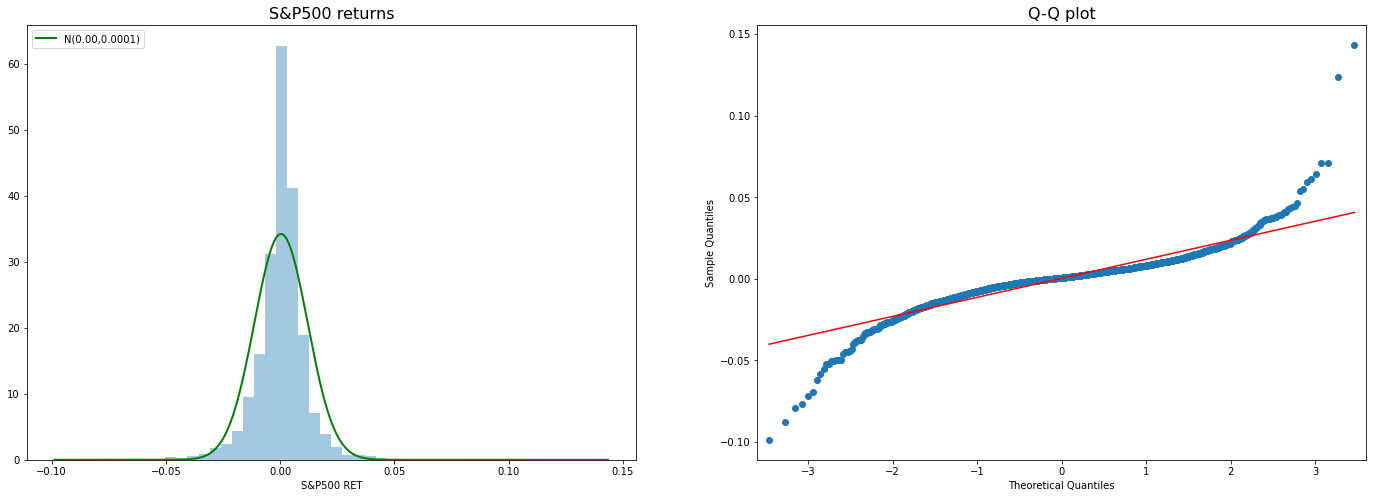

In [9]:
fig,ax = plt.subplots(1,2,figsize=(24,8))

# Histogram (subplot1):
sns.distplot(ret, kde=False,norm_hist=True,ax=ax[0])
ax[0].set_title("S&P500 returns",fontsize=16)
ax[0].plot(rng,norm_pdf,"g",lw=2,label=f'N({mu:.2f},{sigma**2:.4f})')
ax[0].legend(loc="upper left")

## Q-Q plot 
qq = sm.qqplot(ret.values,line='s',ax=ax[1])
ax[1].set_title('Q-Q plot',fontsize=16)

In [10]:
# Q-Qplot is clear, returns are not normally distributed. Fat tails

In [11]:
# Some analysis 
ret.describe()

count    3727.000000
mean        0.000352
std         0.011659
min        -0.098728
25%        -0.003950
50%         0.000702
75%         0.005460
max         0.143460
Name: S&P500 RET, dtype: float64

In [12]:
#Skewness and kurtosis of S&P500 returns. Jarque Bera test confirms returns do not follow a Normal distribution
print("Skewness:",ret.skew())
print("Kurtosis:",ret.kurtosis())
print(stats.jarque_bera(ret))

Skewness: 0.14185374989907534
Kurtosis: 16.7738402575522
Jarque_beraResult(statistic=43580.134860112856, pvalue=0.0)


In [13]:
# Accortding to mean, std, Skewness and kurtosis we can infere distribution is not normal. 
# Specifically we can see kurtosis as the main feature of this distribution : Fat tails
# Besides Jarque Bera normality test would make us reject distribution is normal at 99% level

# Therefore we can reject null hypothesis at the 99% confidence level since pvalue is 0.0 (<0.05). Returns on S&P500 are not normally distributed

<br>

#### Volatility clustering
***

<AxesSubplot:title={'center':'S&P 500 returns'}>

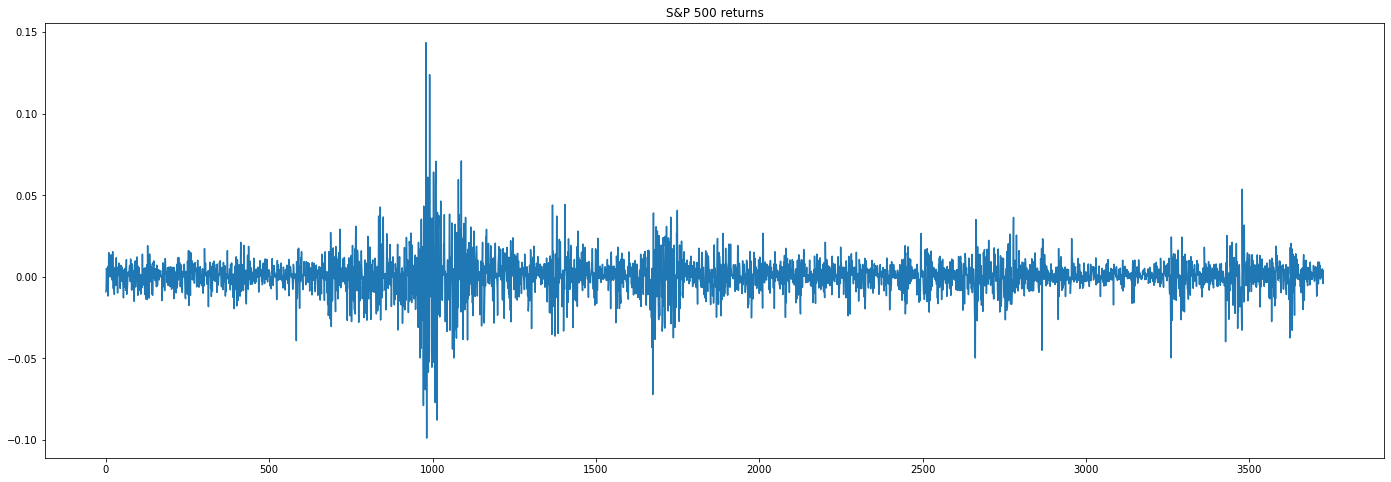

In [14]:
fig,ax = plt.subplots(1,1,figsize=(24,8))
ret.plot(title="S&P 500 returns")

In [15]:
# Volatility seems to cluster (periods of high/low volatility in market returns tend to persist)....Conditional Heteroskedaticity

<br>

#### Autocorrelation in returns
***

In [16]:
# We now take a look to autocorrelation (How similar is a given time series to the lagged version of itself)
# Previous plot shows that returns tend to jump around zero and we see no persistent trends, this means little autocorrelation
# This are not good news for predicting future outcomes, there would be no way to make money if price follows a random walk
# Lets check this more visually through autocorrelation function (ACF)

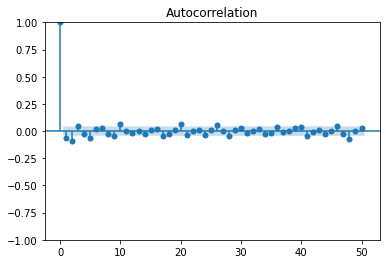

In [17]:
N_LAGS = 50
SIGNIFCANCE_LEVEL=0.01
acf = smt.graphics.plot_acf(ret,lags = N_LAGS,alpha=SIGNIFCANCE_LEVEL)

In [18]:
# Most of the values lie between the confidence interval. We can asume that there is no autocorrelation in the returns

<br>

#### Leverage effect
***

In [19]:
# Volatility measures as rolling standard deviations
df['moving_avg_std_252'] = df[["S&P500 RET"]].rolling(window=252).std()
df['moving_avg_std_21'] = df[["S&P500 RET"]].rolling(window=21).std()

<AxesSubplot:>

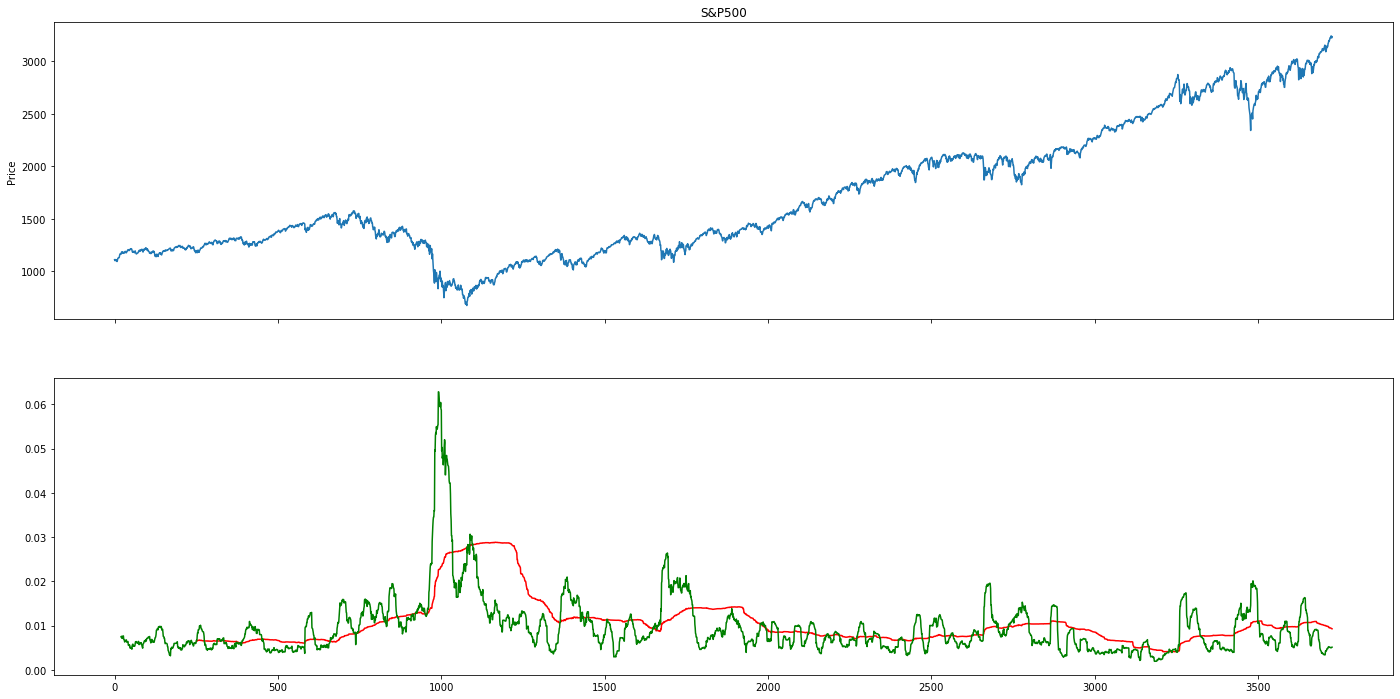

In [20]:
# Series

fig,ax = plt.subplots(2,1,figsize=(24,12),sharex=True)

df.ES.plot(ax=ax[0])
ax[0].set(title='S&P500',ylabel = "Price")

df['moving_avg_std_252'].plot(ax=ax[1],color='r',label = 'Moving Volatility 252d')
df['moving_avg_std_21'].plot(ax=ax[1],color='g',label = 'Moving Volatility 21d')


In [21]:
# We see an important feature of financial time series: asset volatility is negatively correlated with returns.In this case we´re taking a look at realized volatility
# Asset returns volatility is typically considered as the "fear index", volatility increases when market drops, so it is typically negatively correlated to market returns

## 4. Feature Selection

In [22]:
# We would like to have as few features as possible to avoid overfitting (Curse of Dimensionality). The number of configurations grows exponentially as the #
# of features increases--> the number of configurations covered by an observation decreases ---> we learn less and less although we might be able to train the data perfectly
# We need to select useful features only

In [23]:
df2 = df[['Change AVG(5)',
         'C - AVG(200)', 
         'RSI(2)', 'VIX', 
         'Change VIX',       
         'Change EUR-USD',
         'Change 10YR_IR',
         'Change CRUDE OIL',
         'Change NG',
         'Change GOLD',
         'S&P500 RET',
         'RET_LABEL']]

In [24]:
df2.head(10)

,Change AVG(5),C - AVG(200),RSI(2),VIX,Change VIX,Change EUR-USD,Change 10YR_IR,Change CRUDE OIL,Change NG,Change GOLD,S&P500 RET,RET_LABEL
0,-0.004146,1,25.759886,15.05,0.000000,-0.006530,-0.002221,-0.015007,-0.073573,-0.018610,-0.009133,0
1,-0.005492,0,8.580459,15.05,0.024585,0.001461,-0.002358,0.021520,0.032399,-0.004801,-0.008094,1
2,-0.005121,0,3.952030,15.42,0.065499,0.003403,-0.003864,0.020880,-0.007006,0.011819,0.005213,1
3,-0.002372,0,43.141736,16.43,-0.084601,0.006944,0.002748,0.003104,-0.013817,0.001430,0.003608,0
4,-0.002378,0,63.731022,15.04,-0.021941,0.001844,-0.000132,-0.022938,0.014458,-0.005951,-0.008313,0
5,-0.003373,0,23.826584,14.71,0.028552,0.001521,-0.000415,-0.007080,0.046577,0.009579,-0.001812,1
6,-0.001895,0,18.749832,15.13,-0.018506,0.006154,-0.003037,0.030587,0.070195,0.007590,0.006128,1
7,0.000949,0,66.676560,14.85,-0.020875,0.001906,0.000414,-0.008194,0.009707,0.001883,-0.011730,0
8,-0.002439,0,20.377441,14.54,0.050894,0.005471,-0.001374,0.012851,0.053008,0.000000,0.000000,1
9,-0.003170,0,20.377441,15.28,0.085079,0.009778,-0.001380,-0.011419,-0.026527,0.010103,0.014837,1


In [25]:
df2.corr()

,Change AVG(5),C - AVG(200),RSI(2),VIX,Change VIX,Change EUR-USD,Change 10YR_IR,Change CRUDE OIL,Change NG,Change GOLD,S&P500 RET,RET_LABEL
Change AVG(5),1.000000,0.191825,0.621907,-0.135553,-0.186899,0.100478,0.120452,0.096793,0.040289,0.010924,-0.097749,-0.235147
C - AVG(200),0.191825,1.000000,0.191423,-0.425993,-0.016458,0.007275,0.047079,0.025735,0.018956,-0.005131,-0.008187,-0.060068
RSI(2),0.621907,0.191423,1.000000,-0.039569,-0.331181,0.130301,0.218273,0.112426,0.030315,0.032660,-0.040965,-0.465495
VIX,-0.135553,-0.425993,-0.039569,1.000000,-0.060971,0.006130,-0.000726,0.007035,-0.024401,0.008836,0.021031,0.000745
Change VIX,-0.186899,-0.016458,-0.331181,-0.060971,1.000000,-0.086630,-0.200637,-0.070718,-0.011685,0.004282,0.037466,0.275245
Change EUR-USD,0.100478,0.007275,0.130301,0.006130,-0.086630,1.000000,-0.028009,0.091933,0.092906,0.324582,-0.007037,-0.108643
Change 10YR_IR,0.120452,0.047079,0.218273,-0.000726,-0.200637,-0.028009,1.000000,0.103608,0.020111,-0.122200,-0.025387,-0.187505
Change CRUDE OIL,0.096793,0.025735,0.112426,0.007035,-0.070718,0.091933,0.103608,1.000000,0.084182,0.107158,-0.000112,-0.061911
Change NG,0.040289,0.018956,0.030315,-0.024401,-0.011685,0.092906,0.020111,0.084182,1.000000,0.059512,-0.007101,-0.030974
Change GOLD,0.010924,-0.005131,0.032660,0.008836,0.004282,0.324582,-0.122200,0.107158,0.059512,1.000000,-0.004285,-0.012613


Change AVG(5)


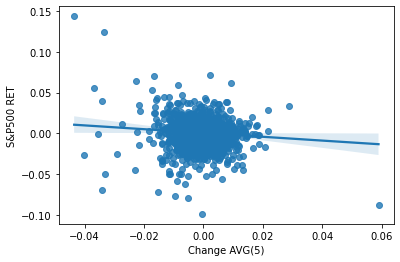

C - AVG(200)


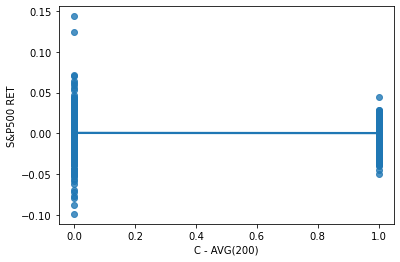

RSI(2)


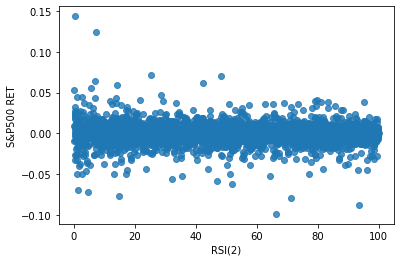

VIX


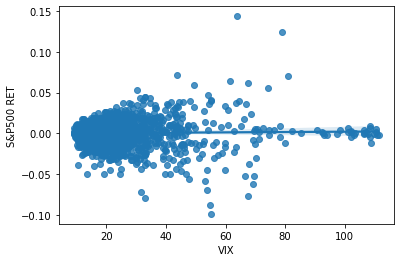

Change VIX


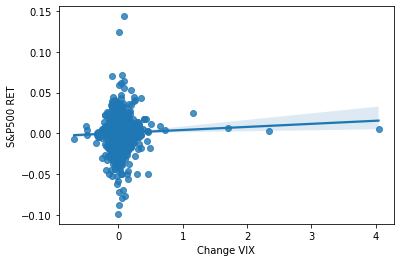

Change EUR-USD


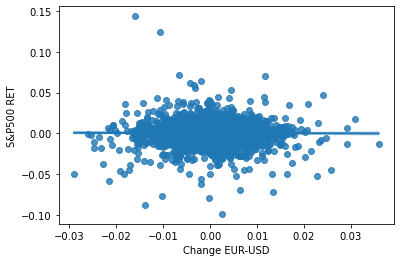

Change 10YR_IR


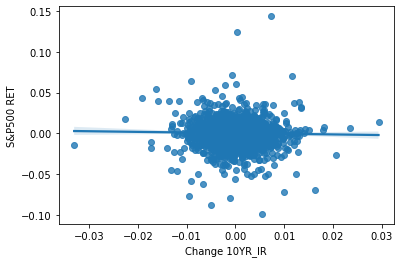

Change CRUDE OIL


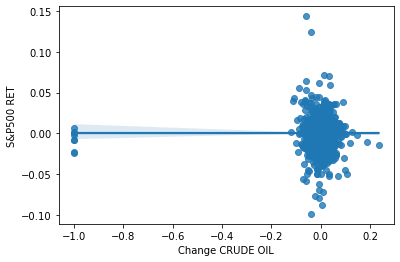

Change NG


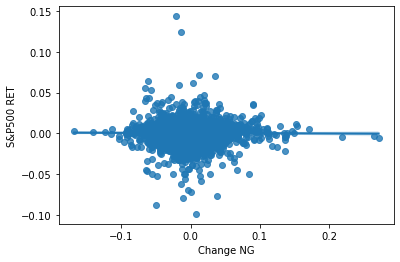

Change GOLD


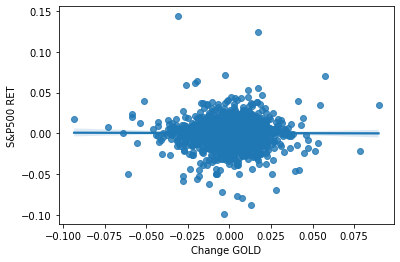

S&P500 RET


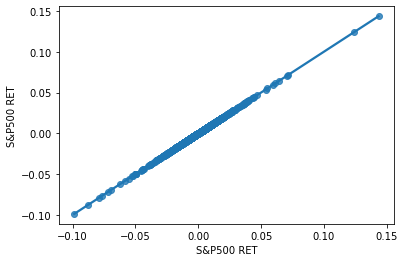

RET_LABEL


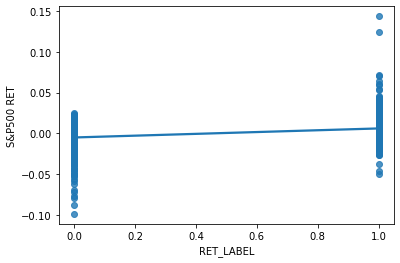

In [26]:
# list = ['Change AVG(5)', 'C - AVG(200)', 'RSI(2)', 'VIX', 'Change VIX','Change EUR-USD', 'Change 10YR_IR', 'Change CRUDE OIL', 'Change NG','Change GOLD', 'S&P500 RET', 'RET_LABEL']

for i in df2:
    print(i)
    sns.regplot(x=i,y='S&P500 RET',data=df2)
    plt.show()
       
      
    

In [38]:
# Create X and y
X = df2.iloc[:,:-2]
y = df2.iloc[:,-1]